# Logistic regression on Criteo dataset without Spark MLlib

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import types as st
from pyspark.sql import functions as sf
from pyspark.sql import Row, DataFrame
from pyspark import RDD
from pyspark import StorageLevel

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plot
from typing import Tuple, Dict

In [4]:
ss = SparkSession \
    .builder \
    .appName("criteo-lr") \
    .master("local[4]") \
    .config("spark.submit.deployMode", "client") \
    .config("spark.driver.memory", "4g") \
    .config("spark.ui.port", "0") \
    .getOrCreate()
ss

## Load dataset

In [5]:
integer_features = [f"int_feat_{i}" for i in range(1, 14)]
categorical_features = [f"cat_feat_{i}" for i in range(1, 27)]

fields = []

fields.append(
    st.StructField("label", st.IntegerType(), nullable=False)
)

for int_feat in integer_features:
    fields.append(st.StructField(int_feat, st.IntegerType(), nullable=True))
    
for cat_feat in categorical_features:
    fields.append(st.StructField(cat_feat, st.StringType(), nullable=True))

schema = st.StructType(fields)

In [6]:
full_df = ss.read.csv(
    path="file:///home/m.tchiboukdjian/master-iasd/large-scale-ml/train.txt",
    sep="\t",
    header=None,
    schema=schema
)

In [7]:
# don't run this cell to use the full dataset
full_df = full_df.sample(0.1).persist(StorageLevel.DISK_ONLY)

In [8]:
full_df.agg(
    sf.count('*').alias('num_examples'),
    sf.sum('label').alias('num_positives'),
    sf.sum(sf.expr('label == 0').cast('int')).alias('num_negatives'),
    sf.mean('label').alias('avg_label')
).toPandas()

,num_examples,num_positives,num_negatives,avg_label
0,4587112,1175346,3411766,0.256228


## Convert to vector with one hot encoding

### Select subset of features based on number of modalities

In [9]:
threshold = 100
num_modalities = {} 
for cat_feat in categorical_features:
    num_modalities[cat_feat] = full_df \
        .filter(sf.col(cat_feat).isNotNull()) \
        .groupby(cat_feat) \
        .count() \
        .filter(sf.col('count') > sf.lit(threshold)) \
        .count()
num_modalities

{'cat_feat_1': 213,
 'cat_feat_2': 484,
 'cat_feat_3': 2552,
 'cat_feat_4': 3535,
 'cat_feat_5': 72,
 'cat_feat_6': 10,
 'cat_feat_7': 5264,
 'cat_feat_8': 120,
 'cat_feat_9': 3,
 'cat_feat_10': 4431,
 'cat_feat_11': 3103,
 'cat_feat_12': 2626,
 'cat_feat_13': 2551,
 'cat_feat_14': 25,
 'cat_feat_15': 2991,
 'cat_feat_16': 2996,
 'cat_feat_17': 10,
 'cat_feat_18': 1673,
 'cat_feat_19': 825,
 'cat_feat_20': 3,
 'cat_feat_21': 2717,
 'cat_feat_22': 8,
 'cat_feat_23': 14,
 'cat_feat_24': 3069,
 'cat_feat_25': 41,
 'cat_feat_26': 2290}

In [10]:
low_card_cat_feat = [cat_feat for cat_feat, num_modalities in num_modalities.items() if num_modalities < 50]
low_card_cat_feat

['cat_feat_6',
 'cat_feat_9',
 'cat_feat_14',
 'cat_feat_17',
 'cat_feat_20',
 'cat_feat_22',
 'cat_feat_23',
 'cat_feat_25']

### Build map for one hot encoding

In [11]:
modalities = {}
for cat_feat in low_card_cat_feat:
    rows = full_df\
        .filter(sf.col(cat_feat).isNotNull())\
        .groupby(cat_feat)\
        .count()\
        .filter(sf.col('count') > sf.lit(threshold))\
        .select(cat_feat)\
        .collect()
    modalities[cat_feat] = [row[cat_feat] for row in rows]

In [12]:
one_hot_encoder = {cat_feat:{} for cat_feat in low_card_cat_feat}
index = 0
for cat_feat in low_card_cat_feat:
    for value in modalities[cat_feat]:
        one_hot_encoder[cat_feat][value] = index
        index += 1
    one_hot_encoder[cat_feat][None] = index
    index += 1
dimension = index + 1 # dimension is nb_of_modalities + 1 for the intercept
dimension

123

### Convert to vector

In [13]:
def row_to_vector(
    row: Row, dimension: int, encoder: Dict[str, Dict[str, int]]
) -> Tuple[np.ndarray, int]:
    x = np.zeros(dimension)
    x[-1] = 1 # for intercept
    y = row['label']
    for feat in encoder.keys():
        value = row[feat]
        index = encoder[feat].get(value, None)
        if index != None:
            x[index] = 1
    return x, y

In [14]:
def convert_to_vectors(
    df: DataFrame, dimension: int, encoder: Dict[str, Dict[str, int]]
) -> RDD:
    features = encoder.keys()
    return df\
        .select('label', *features).rdd\
        .map(lambda row: row_to_vector(row, dimension, encoder))

In [15]:
convert_to_vectors(full_df, dimension, one_hot_encoder).first()

(array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1.]),
 0)

## Compute loss

In [16]:
def sigmoid(x: float) -> float:
    return 1 / (1 + math.exp(-x))

In [17]:
X = np.arange(-10, 10, 0.01)

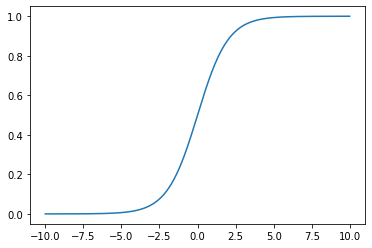

In [18]:
plot.plot(X, [sigmoid(x) for x in X])

In [19]:
def point_predict(x: np.ndarray, model: np.ndarray) -> float:
    return sigmoid(np.dot(x, model))

In [20]:
def point_loss(prediction: float, y: int) -> float:
    return - y * math.log(prediction) - (1-y) * math.log(1-prediction)

In [21]:
def compute_loss(vec_label_rdd: RDD, model: np.ndarray, num_examples: int) -> float:
    sum_loss = vec_label_rdd\
        .map(lambda vec_lab: point_loss(point_predict(vec_lab[0], model), vec_lab[1]))\
        .reduce(lambda u, v: u+v)
    return sum_loss / num_examples

## Compute gradient of the loss

In [22]:
def point_gradient(x: np.ndarray, y: int, model: np.ndarray) -> float:
    p = sigmoid(np.dot(x, model))
    return (p - y) *  x

In [23]:
def compute_gradient(vec_label_rdd: RDD, model: np.ndarray, num_examples: int) -> np.ndarray:
    sum_gradient = vec_label_rdd\
        .map(lambda vec_lab: point_gradient(vec_lab[0], vec_lab[1], model))\
        .reduce(lambda u, v: u+v)
    return sum_gradient / num_examples

## Check gradient with finite differences

In [24]:
def point_gradient_fd(x, y, model, h=0.001):
    dimension = len(x)
    gradient = np.zeros(dimension)
    for i in range(0, dimension):
        delta = np.zeros(dimension)
        delta[i] = h
        
        loss_up = point_loss(point_predict(x, model+delta), y)
        loss_down = point_loss(point_predict(x, model-delta), y)
        
        gradient[i] = (loss_up - loss_down) / (2*h)
    return gradient

In [25]:
model = np.random.uniform(-1.0, 1.0, size=dimension)
x = np.random.uniform(-1.0, 1.0, size=dimension)
y = 0

In [26]:
np.sum(np.abs(point_gradient_fd(x, y, model) - point_gradient(x, y, model)))

6.859785633387024e-08

## Distributed Gradient Descent

In [27]:
def logit(x: float) -> float:
    return math.log( x / (1-x) )

In [28]:
np.sum(np.abs([x - logit(sigmoid(x)) for x in X]))

1.3486069205814746e-10

In [29]:
def smart_init(dimension: int, avg_label: float) -> np.ndarray:
    init_model = np.zeros(dimension)
    init_model[-1] = logit(avg_label)
    return init_model

In [30]:
def train(
    training_set: DataFrame,
    dimension: int,
    encoder: Dict[str, Dict[str, int]],
    nb_iter: int,
    lr: float
) -> Tuple[np.ndarray, float]:
    num_examples, avg_label = training_set.agg(
        sf.count('*').alias('num_examples'),
        sf.mean('label').alias('avg_label')
    ).collect()[0]
    print(f'Num examples: {num_examples}, average label: {avg_label}')
    model = smart_init(dimension, avg_label)
    vector_label_rdd = convert_to_vectors(training_set, dimension, encoder).persist()
    for it in range(0, nb_iter):
        loss = compute_loss(vector_label_rdd, model, num_examples)
        print(f'Loss at step {it}: {loss}')
        gradient = compute_gradient(vector_label_rdd, model, num_examples)
        model -= lr * gradient
    final_loss = compute_loss(vector_label_rdd, model, num_examples)
    print(f'Loss at step {nb_iter}: {final_loss}')
    return model, final_loss

In [31]:
model, loss = train(full_df, dimension, one_hot_encoder, 10, 1)

Num examples: 4587112, average label: 0.2562278836880373
Loss at step 0: 0.5690743077878105
Loss at step 1: 0.567098901261674
Loss at step 2: 0.5653612477791176
Loss at step 3: 0.5637904281964999
Loss at step 4: 0.5623654748963451
Loss at step 5: 0.5610700012847851
Loss at step 6: 0.5598897119875923
Loss at step 7: 0.558812041231945
Loss at step 8: 0.5578259287808576
Loss at step 9: 0.5569216301112553
Loss at step 10: 0.5560905512971541


In [32]:
print(f'intercept -> {model[-1]}')
for dim in one_hot_encoder.keys():
    for mod, index in one_hot_encoder[dim].items():
        print(f'{dim}={mod} -> {model[index]}')

intercept -> -1.099098773067705
cat_feat_6=fbad5c96 -> -0.01736417639057321
cat_feat_6=3bf701e7 -> 0.0028007628432673176
cat_feat_6=c76aecf6 -> -2.812040656412048e-06
cat_feat_6=c05778d5 -> -4.6543347297301904e-05
cat_feat_6=f1f2de2d -> 2.3187664952036454e-05
cat_feat_6=6f6d9be8 -> 0.020121650352710366
cat_feat_6=13718bbd -> -0.01253037022999402
cat_feat_6=fe6b92e5 -> 0.01170886627712748
cat_feat_6=7e0ccccf -> -0.036299666123925704
cat_feat_6=e3520422 -> -6.442243255570053e-05
cat_feat_6=None -> -0.0017666690493169832
cat_feat_9=a73ee510 -> 0.08003105070557046
cat_feat_9=a18233ea -> -0.0002292024376455462
cat_feat_9=7cc72ec2 -> -0.11323314786915856
cat_feat_9=None -> 0.0
cat_feat_14=f862f261 -> -0.015292712310671183
cat_feat_14=243a4e68 -> -0.00013268581466148737
cat_feat_14=d2dfe871 -> 0.003961487519168026
cat_feat_14=91233270 -> -0.00012140729692048738
cat_feat_14=b28479f6 -> -0.11062718878760078
cat_feat_14=dcd762ee -> 0.0016913482719173865
cat_feat_14=e8dce07a -> 1.1856033580004198

In [33]:
ss.stop()

### More questions

* use sparse vectors
* add feature hashing
* merge loss and gradient computation in one function
* use lbfgs from scipy